# Example simulations with different gains, fully random networks

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from disp import set_plot, set_color
from ntwk import SoftmaxNtwk
from time_stats import get_isi_cv_1

In [2]:
N = 1000
D = 5

J = np.nan*np.zeros((D, D, N, N))

for d_to in range(D):
    for d_from in range(D):
        J[d_to, d_from, :, :] = np.random.randn(N, N)*np.sqrt(D/N)

In [3]:
ntwk = SoftmaxNtwk(J)

In [4]:
x_0 = np.random.randn(N, D)
g = np.inf
rslts = []
t, xs, ys = ntwk.run(g=g, t_max=5000, x_0=x_0)

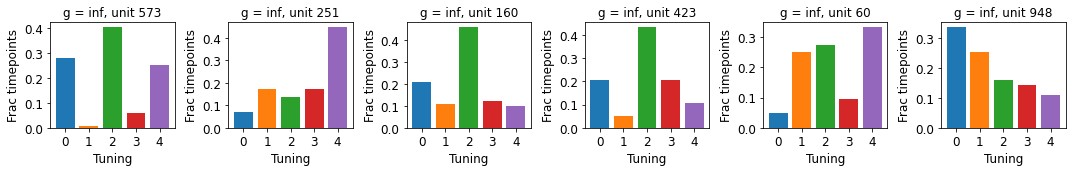

In [5]:
# example single-unit time averages
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
iunits = np.random.permutation(N)[:6]

fig, axs = plt.subplots(1, len(iunits), figsize=(15, 2.5), tight_layout=True)

for iunit, ax in zip(iunits, axs):
    ax.bar(np.arange(D), ys[:, iunit, :].mean(0), color=color_cycle)

    set_plot(ax, x_ticks=range(D), x_label='Tuning', y_label='Frac timepoints', title=f'g = {g}, unit {iunit}')

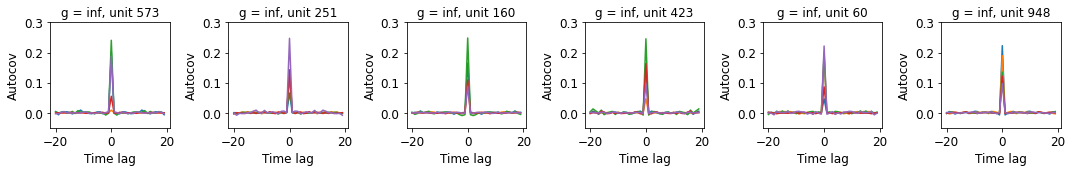

In [6]:
# example autocorrelation functions 
from time_stats import xcov_conv_tri

fig, axs = plt.subplots(1, len(iunits), figsize=(15, 2.5), tight_layout=True)

for iunit, ax in zip(iunits, axs):
    for d, color in zip(range(D), color_cycle):
        y = ys[:, iunit, d]
        acov, t = xcov_conv_tri(y, y)
        mt = (-20 <= t)&(t < 20)
        ax.plot(t[mt], acov[mt], c=color)

    set_plot(ax, y_lim=(-.05, .3), x_label='Time lag', y_label='Autocov', title=f'g = {g}, unit {iunit}')

In [20]:
# run second network with larger R to get firing rate distribution
D2 = 12

J2 = np.nan*np.zeros((D2, D2, N, N))

for d_to in range(D2):
    for d_from in range(D2):
        J2[d_to, d_from, :, :] = np.random.randn(N, N)*np.sqrt(D2/N)
        
ntwk_2 = SoftmaxNtwk(J2)

x_0_2 = np.random.randn(N, D2)
t_2, xs_2, ys_2 = ntwk_2.run(g=np.inf, t_max=3000, x_0=x_0_2, progress=50)

...........................................................

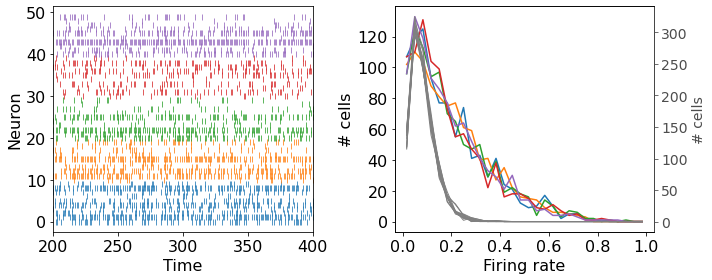

In [21]:
# raster plot and firing rate distributions for spiking limit
fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
nplot_cotuned = 10

for d in range(D):
    inrns = np.random.permutation(N)[:nplot_cotuned]
    tspks, cspks = ys[:, inrns, d].nonzero()
    axs[0].scatter(tspks, cspks+d*nplot_cotuned, marker='|', lw=.75)
    
set_plot(axs[0], x_lim=(200, 400), x_ticks=(200, 250, 300, 350, 400), x_label='Time', y_label='Neuron', font_size=16)

bins = np.linspace(0, 1, 31)
binc = .5*(bins[:-1] + bins[1:])

for d in range(D):
    rates = ys[:, :, d].mean(axis=0)  # time average
    cts_rate = np.histogram(rates, bins=bins)[0]
    
    axs[1].plot(binc, cts_rate)
    
# plot second set of histograms
ax_twin = axs[1].twinx()

for d in range(D2):
    rates = ys_2[:, :, d].mean(axis=0)
    cts_rate = np.histogram(rates, bins=bins)[0]
    
    ax_twin.plot(binc, cts_rate, c='gray', lw=1)
    
set_plot(ax_twin, y_label=f'# cells', font_size=14)
set_color(ax_twin, (.3, .3, .3))
    
set_plot(axs[1], x_label='Firing rate', y_label='# cells', font_size=16)

fig.savefig('figs/main/1_raster_and_firing_rate_distr.svg')

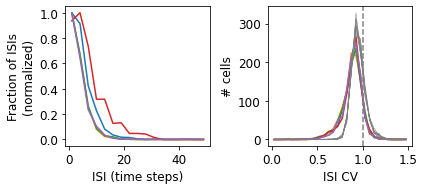

In [23]:
from time_stats import get_isi_cv_2

get_isi_cv = get_isi_cv_1

fig, axs = plt.subplots(1, 2, figsize=(6, 2.75), tight_layout=True)

isi_bins = np.arange(-.5, 50.6, 3)
isi_binc = .5*(isi_bins[:-1] + isi_bins[1:])

for d in range(D):
    inrns_plot = np.random.permutation(N)[:1]
    for inrn in inrns_plot:
        tspks = ys[:, inrn, d].nonzero()[0]
        isis = np.diff(tspks)
        ct_isis = np.histogram(isis, bins=isi_bins)[0]
        axs[0].plot(isi_binc, ct_isis/ct_isis.max())
        
set_plot(axs[0], x_label='ISI (time steps)', y_label='Fraction of ISIs\n(normalized)')

isi_cvs_all = []
for d in range(D):
    isi_cvs = []
    for cnrn in range(N):
        spks = ys[:, cnrn, d]
        isi_cvs.append(get_isi_cv(spks))
    isi_cvs_all.append(isi_cvs)
    
bins = np.linspace(0, 1.5, 31)
binc = .5*(bins[:-1] + bins[1:])
for isi_cvs in isi_cvs_all:
    cts = np.histogram(isi_cvs, bins)[0]
    axs[1].plot(binc, cts)
    
# repeat for larger network
isi_cvs_all = []
for d in range(D2):
    isi_cvs = []
    for cnrn in range(N):
        spks = ys_2[:, cnrn, d]
        isi_cvs.append(get_isi_cv(spks))
    isi_cvs_all.append(isi_cvs)
    
bins = np.linspace(0, 1.5, 31)
binc = .5*(bins[:-1] + bins[1:])
for isi_cvs in isi_cvs_all:
    cts = np.histogram(isi_cvs, bins)[0]
    axs[1].plot(binc, cts, c='gray', lw=.5)
    
axs[1].axvline(1, color='gray', ls='--')
    
set_plot(axs[1], x_label=r'ISI CV', y_label='# cells')

fig.savefig('figs/main/2_isis.svg')